In [1]:
#imports
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn import ensemble
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import log_loss, f1_score,classification_report,confusion_matrix,accuracy_score
color = sns.color_palette()

%matplotlib inline

import keras
from keras.preprocessing import text
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D,SpatialDropout1D, GlobalMaxPool1D
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Lambda, Activation
from keras.optimizers import RMSprop, Adam
from keras.layers.normalization import BatchNormalization
from keras.layers.wrappers import Bidirectional
from keras import backend as K
from keras.layers import Input,GRU
from keras.layers.merge import add, concatenate
from keras.layers import GaussianDropout
from keras.layers.core import *

Using TensorFlow backend.


In [2]:
data_dict = joblib.load("/media/SAP_project/LG-ContentSegmentation/audio_datasets/genres_dump")

In [3]:
data_dict.keys()

dict_keys(['category_dict', 'label_list', 'embedings_list'])

In [4]:
# read data
labels = data_dict["label_list"]
embedings_list = data_dict["embedings_list"]
category_dict = data_dict["category_dict"]
inv_category_dict = {category_dict[k]:k for k in category_dict}

In [5]:
# define some params
seq_length = embedings_list[0].shape[0]
embed_dim = embedings_list[0].shape[1]
nb_classes = len(category_dict)

target = np.zeros((len(labels),len(category_dict)),dtype=np.float32)
data = np.zeros((len(embedings_list),seq_length,embed_dim),dtype=np.float32)

for i in range(len(target)):
    target[i,inv_category_dict[labels[i]]] = 1.0
    data[i,:,:] = embedings_list[i]

labels = [inv_category_dict[k] for k in labels]

In [6]:
tr_data,te_data, y_tr, y_te = train_test_split(data,target,test_size=0.2,stratify=labels)

In [7]:
tr_data.shape

(800, 31, 128)

In [8]:
y_tr.shape

(800, 10)

In [9]:
tr_data, val_data, y_tr, y_val = train_test_split(tr_data,y_tr,test_size=0.2)

In [10]:
y_tr

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [16]:
model = Sequential()
model.add(Layer(input_shape=(None,embed_dim,)))
#model.add(GlobalAveragePooling1D())
model.add(Bidirectional(GRU(64,recurrent_dropout=0.2,return_sequences=True)))
model.add(GaussianDropout(0.05))
#model.add(Dropout(0.2))
model.add(GlobalAveragePooling1D())
model.add(Dense(nb_classes,activation="softmax"))

model.compile(loss='categorical_crossentropy',
             optimizer='adam',
            metrics=['accuracy'])

In [12]:
model = Sequential()
model.add(Layer(input_shape=(seq_length,embed_dim,)))
#model.add(GlobalAveragePooling1D())
model.add(Conv1D(64,kernel_size=3))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling1D())
model.add(Dense(nb_classes,activation="softmax"))

model.compile(loss='categorical_crossentropy',
             optimizer='adam',
            metrics=['accuracy'])

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_3 (Layer)              (None, None, 128)         0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 128)         74112     
_________________________________________________________________
gaussian_dropout_2 (Gaussian (None, None, 128)         0         
_________________________________________________________________
global_average_pooling1d_3 ( (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 75,402
Trainable params: 75,402
Non-trainable params: 0
_________________________________________________________________


In [18]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler,EarlyStopping
lr_scheduler_callback = LearningRateScheduler(lambda epoch:
                                                      0.003 if epoch < 5
                                                      else 0.001)

In [19]:
filepath = './model_cpt/gru_64_avg_pool_gaus_do_batch_16.h5'
my_callback = keras.callbacks.ModelCheckpoint(filepath, monitor = 'val_loss', verbose = 0, save_best_only = True, save_weights_only=False, mode='auto')
model.fit(tr_data, y_tr,batch_size=16,
          validation_data = (val_data,y_val),
          epochs=300,
          callbacks = [my_callback, lr_scheduler_callback,EarlyStopping(monitor='val_loss', patience = 7, verbose = 0)])

Train on 640 samples, validate on 160 samples
Epoch 1/300
640/640 [==============================] - 4s 6ms/step - loss: 2.0957 - acc: 0.3063 - val_loss: 1.9548 - val_acc: 0.4750

In [20]:
from keras.models import load_model
model = load_model("./model_cpt/gru_64_avg_pool_gaus_do.h5")

In [116]:
from keras.models import load_model
model = load_model("./model_cpt/gru_64_avg_pool_gaus_do_batch_16.h5")

In [21]:
y_pred = model.predict(te_data)

In [22]:
y_pred

array([[2.7877858e-02, 1.7579879e-03, 4.4392720e-03, ..., 4.2637896e-02,
        3.4476295e-01, 4.5366872e-02],
       [7.6780759e-02, 1.5792416e-02, 5.8783296e-02, ..., 2.1279350e-02,
        1.8199049e-02, 1.2188827e-01],
       [6.4984513e-03, 7.6120731e-04, 2.1982405e-03, ..., 2.2635744e-03,
        1.4807462e-03, 3.0620368e-02],
       ...,
       [1.3116755e-01, 2.6310576e-04, 4.2060707e-02, ..., 2.2395758e-03,
        6.2004559e-02, 6.9302285e-01],
       [1.4090386e-01, 1.0716548e-02, 1.6330221e-01, ..., 8.1226356e-02,
        7.5482293e-03, 4.8017851e-01],
       [2.2237159e-03, 1.5866928e-03, 2.2550668e-03, ..., 3.2384068e-01,
        2.9344587e-02, 2.1419523e-02]], dtype=float32)

In [23]:
pred_label = [np.argmax(v) for v in y_pred]
true_label = [np.argmax(v) for v in y_te]

In [24]:
f1_score(true_label,pred_label,average="micro")

0.805

In [25]:
print(classification_report(true_label,pred_label))

              precision    recall  f1-score   support

           0       0.70      0.80      0.74        20
           1       1.00      1.00      1.00        20
           2       0.79      0.55      0.65        20
           3       1.00      0.50      0.67        20
           4       0.86      0.95      0.90        20
           5       0.73      0.95      0.83        20
           6       0.90      0.95      0.93        20
           7       0.70      0.95      0.81        20
           8       0.75      0.75      0.75        20
           9       0.76      0.65      0.70        20

   micro avg       0.81      0.81      0.81       200
   macro avg       0.82      0.81      0.80       200
weighted avg       0.82      0.81      0.80       200



In [26]:
accuracy_score(true_label, pred_label)

0.805

In [27]:
confusion_matrix(true_label,pred_label)

array([[16,  0,  0,  0,  0,  4,  0,  0,  0,  0],
       [ 0, 20,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 3,  0, 11,  0,  0,  3,  0,  2,  0,  1],
       [ 0,  0,  1, 10,  0,  0,  0,  5,  3,  1],
       [ 0,  0,  0,  0, 19,  0,  0,  0,  1,  0],
       [ 1,  0,  0,  0,  0, 19,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 19,  0,  0,  1],
       [ 0,  0,  0,  0,  1,  0,  0, 19,  0,  0],
       [ 2,  0,  0,  0,  2,  0,  0,  0, 15,  1],
       [ 1,  0,  2,  0,  0,  0,  2,  1,  1, 13]])

In [28]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [29]:
class_list = [category_dict[v] for v in category_dict]

Confusion matrix, without normalization
Normalized confusion matrix


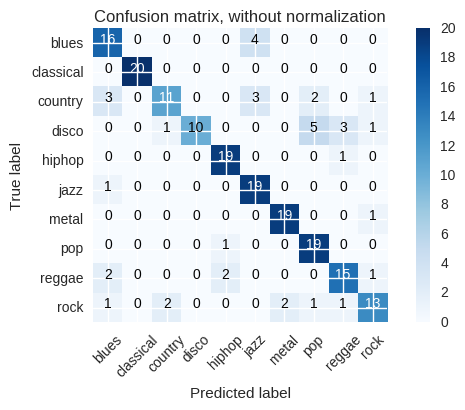

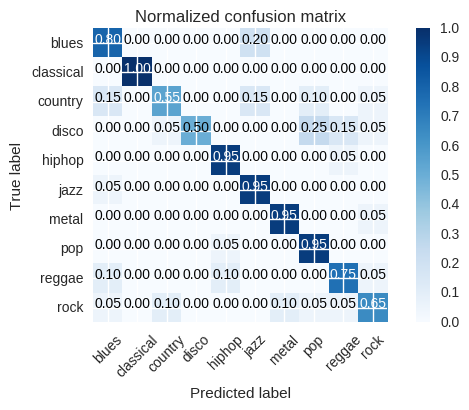

In [30]:
# Compute confusion matrix
import itertools
cnf_matrix = confusion_matrix(true_label,pred_label)
#np.set_printoptions(precision=15)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_list,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_list, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [31]:
category_dict

{0: 'blues',
 1: 'classical',
 2: 'country',
 3: 'disco',
 4: 'hiphop',
 5: 'jazz',
 6: 'metal',
 7: 'pop',
 8: 'reggae',
 9: 'rock'}